<a href="https://colab.research.google.com/github/GrzegorzAndrzejczak/Programowanie-w-Pythonie/blob/main/CASE-lighthouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dane: lighthouse.csv

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


np.random.seed(1)  # for repeatability
# Load the data on the recorded positions and plot their distribution as an histogram.
d = pd.read_csv('sample_data/lighthouse.csv')
N = 5  # number of measurements
D = d.values[:N]
print(D,f"średnio: {D.mean()}")

ndim = 2  # number of parameters in the model
nwalkers = 10000  # number of MCMC walkers = the size of each sample
# nburn = 500  # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take - czyli zostaje 500:10000


def log_prior(a,b):
    mask = b<=0
    b[mask] = 0
    result = -b**(-1)
    # result[mask] = -np.inf
    return result  #   //flat prior, składnik 1/b odsuwa od b=0

def log_likelihood(a, b, Data):
    mask = b<=0
    b[mask] = 0
    result = -np.sum(np.log((Data - a)**2 + b**2)-np.log(b), axis=0)
    # result[mask] = -np.inf
    return result

def log_posterior(a, b, Data):
    warnings.simplefilter("ignore")
    return log_prior(a, b) + log_likelihood(a, b, Data)

def compute_log_prob(coords):
    log_prob = np.array([log_posterior(*p, D) for p in coords])
    # to będzie spowalniać dla większego rozmiaru próbek - nwalkers
    return log_prob



[[ 31.04551878]
 [ 39.15193522]
 [  1.81317194]
 [-10.04647801]
 [ -2.2359284 ]] średnio: 11.945643906451632


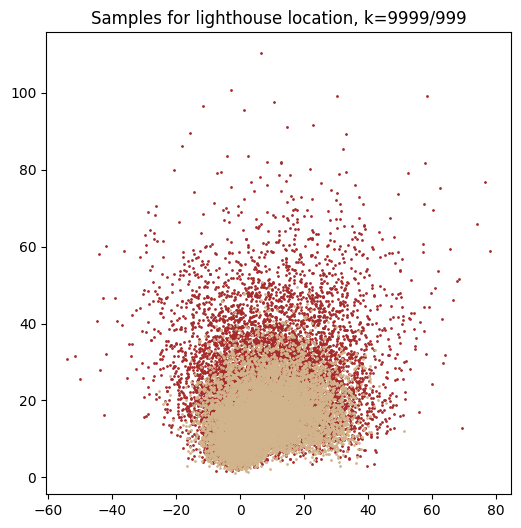

In [14]:
paths = np.empty((nsteps, nwalkers, ndim), dtype = np.float32)
np.random.seed(123)
ab = np.random.rand(nwalkers,ndim)*20
log_post = log_posterior(*ab.T, D)

for k_ in range(nsteps):
    # ab_ = ab + np.random.randn(nwalkers,ndim)/10     # ok. 0.245...0.18...
    ab_ = ab + np.random.randn(nwalkers,ndim)/3     # !!! był DUŻY BŁĄD: (ndim) - a przecież
                                                    #   każda para zmienia się indywidualnie!
    log_post_ = log_posterior(*ab_.T, D)
    H_ = log_post_ - log_post
    u_ = np.log(np.random.uniform(size=nwalkers))
    where = u_ < H_
    ab[where] = ab_[where]
    log_post[where] = log_post_[where]
    paths[k_] = ab

_, axn = plt.subplots(1, 1, figsize=(6, 6))
axn.scatter(*paths[k_].T, s=1, c="brown")
axn.scatter(*paths[k_//10].T, s=1, c="tan")
# axs.set_aspect(1)
axn.set_title(f"Samples for lighthouse location, k={k_}/{k_//10}")
plt.show(block=False)


    0:  0.737; [ 9.988907 10.02545 ]
 2000:  0.309; [ 7.338866 17.971455]
 4000:  0.299; [ 7.1457267 20.035841 ]
 6000:  0.292; [ 7.3456187 21.558615 ]
 8000:  0.299; [ 7.803815 22.522102]


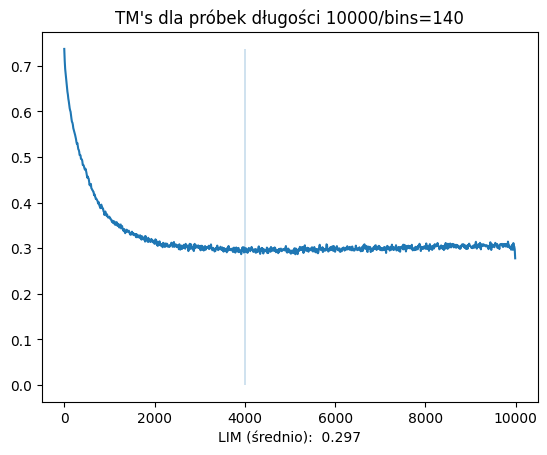

In [15]:
path = paths[-1]    # ostatnia - graniczna
bins = 140
Hb, xb, yb = np.histogram2d(*path.T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))    #
for k in np.arange(0,nsteps,2000):
    path_ = paths[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))
    tm_ = np.abs(H_ - Hb).sum()/2*(140/bins)**2
    print(f'{k:5}: {tm_:6.3f}; {path_.mean(axis=1)}')
n_rang = np.arange(nsteps,step=10)
tm_vals = np.empty_like(n_rang, dtype=np.float32)
for i,k in enumerate(n_rang):
    path_ = paths[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))  # density=True,
    tm_ = np.abs(H_ - Hb).sum()/2
    tm_vals[i] = tm_
tm_vals *= (140/bins)**2   # podział na bins^2 zamiast 140^2
fig, ax0 = plt.subplots()
ax0.plot(n_rang, tm_vals)
nburn = 4000
ax0.vlines(nburn, 0, tm_vals[0],lw=.3)
ax0.set_title(f"TM's dla próbek długości {nwalkers}/bins={bins}")
ax0.set_xlabel(f"LIM (średnio): {tm_vals[nburn//10-100:nburn//10+100].mean():6.3f}");    # 100: 0.174,  140: 0.232


Wygląda na to, że próbki o długości 10K modyfikowane (warunkowo - MH) wg reguły
    ab_ = ab + np.random.randn(nwalkers,ndim)/3

stabilizują błąd $\;\sim\!\|\cdot\|_{TM}$ na poziomie ok. **0.297** dla **nsteps=4K.**

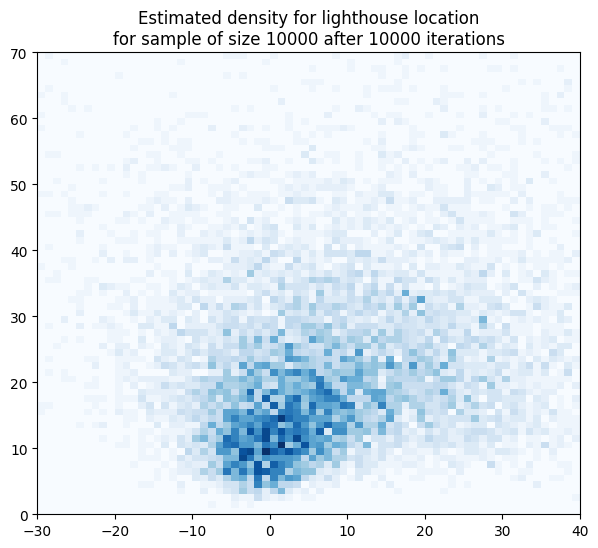

In [6]:
path = paths[-1]
Hb, xb, yb = np.histogram2d(*path.T, bins=140, density=True, range=np.asarray([[-70,70],[0,140]]))    # density=True,
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
Xb, Yb = np.meshgrid(xb, yb)
ax.set_xlim(-30,40);
ax.set_ylim(0,70);
ax.pcolormesh(Xb, Yb, Hb.T, cmap="Blues");
ax.set_title(f"Estimated density for lighthouse location\n"
f"for sample of size {nwalkers} after {nsteps} iterations");
# cntr = ax.tricontourf(*path.T, Hb, levels=15, cmap="RdBu_r")
# fig.colorbar(cntr, ax=ax)

Dla odmiany, próbki o długości 10K modyfikowane (warunkowo - MH) wg reguły
    ab_ = ab + np.random.randn(nwalkers,ndim)/10

stabilizują błąd $\;\sim\!\|\cdot\|_{TM}$ na poziomie ok. **0.211** dla **nsteps=12.5K.**

    0:  0.603; [ 9.995653 10.001437]
 2000:  0.410; [ 9.138518 12.455467]
 4000:  0.314; [ 8.488342 13.616395]
 6000:  0.257; [ 8.054673 14.486233]
 8000:  0.227; [ 7.8198915 15.2003565]
10000:  0.209; [ 7.622517 15.717586]
12000:  0.202; [ 7.4446907 16.210104 ]


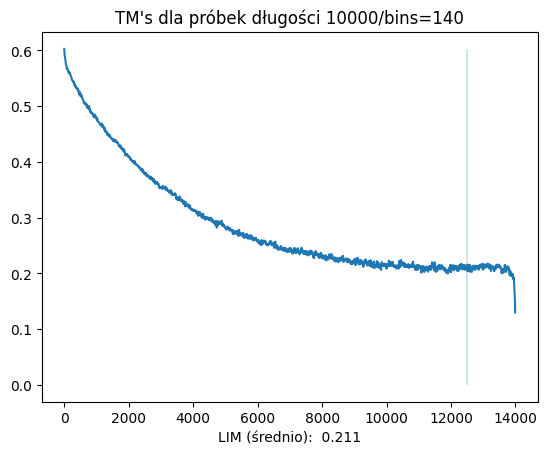

In [18]:
nsteps = 14000
paths = np.empty((nsteps, nwalkers, ndim), dtype = np.float32)
np.random.seed(123)
ab = np.random.rand(nwalkers,ndim)*20
log_post = log_posterior(*ab.T, D)

for k_ in range(nsteps):
    ab_ = ab + np.random.randn(nwalkers,ndim)/10
    log_post_ = log_posterior(*ab_.T, D)
    H_ = log_post_ - log_post
    u_ = np.log(np.random.uniform(size=nwalkers))
    where = u_ < H_
    ab[where] = ab_[where]
    log_post[where] = log_post_[where]
    paths[k_] = ab
path = paths[-1]    # ostatnia - graniczna
bins = 140
Hb, xb, yb = np.histogram2d(*path.T, bins=bins, density=True, range=np.asarray([[-70,70],[0,140]]))    #
for k in np.arange(0,nsteps,2000):
    path_ = paths[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))
    tm_ = np.abs(H_ - Hb).sum()/2*(140/bins)**2
    print(f'{k:5}: {tm_:6.3f}; {path_.mean(axis=1)}')
n_rang = np.arange(nsteps,step=10)
tm_vals = np.empty_like(n_rang, dtype=np.float32)
for i,k in enumerate(n_rang):
    path_ = paths[k].T
    H_, _, _ = np.histogram2d(*path_, bins=bins, density=True, range=np.asarray([[-70, 70], [0, 140]]))  # density=True,
    tm_ = np.abs(H_ - Hb).sum()/2
    tm_vals[i] = tm_
tm_vals *= (140/bins)**2   # podział na bins^2 zamiast 140^2
fig, ax0 = plt.subplots()
ax0.plot(n_rang, tm_vals)
nburn = 12500
ax0.vlines(nburn, 0, tm_vals[0],lw=.3)
ax0.set_title(f"TM's dla próbek długości {nwalkers}/bins={bins}")
ax0.set_xlabel(f"LIM (średnio): {tm_vals[nburn//10-100:nburn//10+100].mean():6.3f}");    # 100: 0.174,  140: 0.232

